<h1>Kobe Bryant Shot Selection</h1>

<h4>Import necessary libraries:</h4>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc

<h4>Load the data:</h4>

In [2]:
all_data = pd.read_csv('data.csv')

data = all_data[all_data['shot_made_flag'].notnull()].reset_index(drop = True).drop_duplicates()
data['game_date'] = pd.to_datetime(data['game_date'])

data

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
1,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
2,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
3,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
4,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,Driving Layup Shot,Layup,382,49900088,34.0443,0,0,-118.2698,7,4,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30692
25693,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693
25694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30695
25695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,...,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30696


<h4>Check what Kobe's favorite type of shot is:</h4>

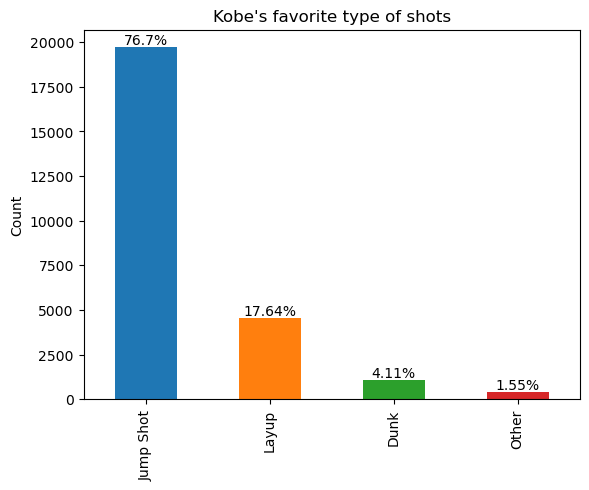

In [3]:
top_3_shots = data['combined_shot_type'].value_counts().head(3)
top_3_shots['Other'] = data['combined_shot_type'].value_counts()[3:].sum()

colors = [(31/255, 119/255, 180/255),
          (255/255, 127/255, 14/255),
          (44/255, 160/255, 44/255),
          (214/255, 39/255, 40/255)]

total_shots = data['combined_shot_type'].count()
percentages = (top_3_shots / total_shots * 100).round(2)

ax = top_3_shots.plot(kind = 'bar', color = colors)

for i, v in enumerate(top_3_shots):
    ax.text(i, v + 5, f'{percentages[i]}%', ha = 'center', va = 'bottom')

plt.title("Kobe's favorite type of shots")
plt.ylabel("Count")
plt.show()

<h4>Shot attempts as a function of time (considering a 12min long periods and 5min overtime):</h4>

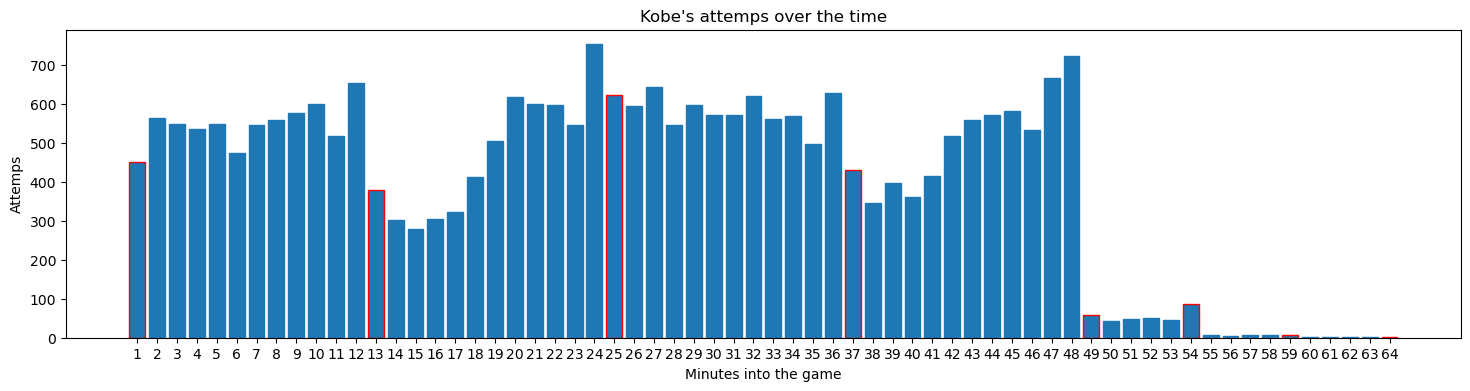

In [10]:
data['current_minute_playing'] = np.where(data['period'] > 4, (4 * 12 + (data['period'] - 5) * 5), ((data['period'] - 1) * 12)) + (12 - data['minutes_remaining']) + np.where(data['seconds_remaining'] == 0, 1, 0)

x = np.arange(1, len(data['current_minute_playing'].value_counts().sort_index()) + 1)

edge_colors = ['red' if i in [1, 13, 25, 37, 49, 54, 59, 64] else '#1f77b4' for i in x]

plt.figure(figsize = (18, 4))

plt.bar(x, data['current_minute_playing'].value_counts().sort_index().tolist(), edgecolor = edge_colors)
plt.xticks(x);
plt.title("Kobe's attemps over the time")
plt.xlabel("Minutes into the game")
plt.ylabel("Attemps")
plt.show()

It seems like Kobe is taking crucial shots at the end of every period.<br>
At the beginning of the 2nd and 4th period, he's usually out of the game, considering the number of attempts in that time.<br>

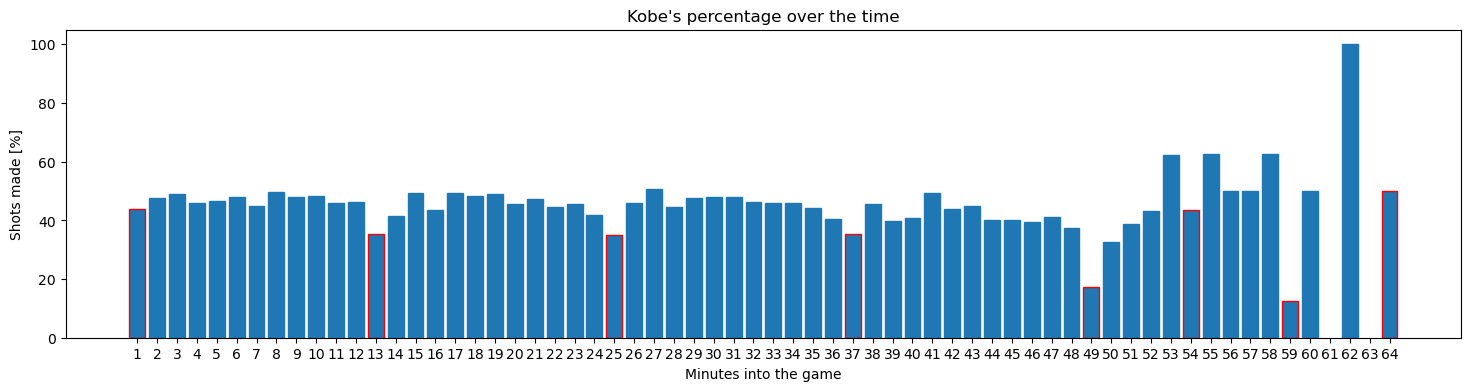

In [12]:
x = np.arange(1, len(((data['current_minute_playing'][data['shot_made_flag'] == 1].value_counts().sort_index() / data['current_minute_playing'].value_counts().sort_index()) * 100).tolist()) + 1)

plt.figure(figsize = (18, 4))

plt.bar(x, ((data['current_minute_playing'][data['shot_made_flag'] == 1].value_counts().sort_index() / data['current_minute_playing'].value_counts().sort_index()) * 100).tolist(), edgecolor = edge_colors)
plt.xticks(x);
plt.title("Kobe's percentage over the time")
plt.xlabel("Minutes into the game")
plt.ylabel("Shots made [%]")
plt.show()

Kobe's shooting percentage is at its lowest at the start of each period. This could be due to breaks between periods. As each period progresses, the percentage is slightly lower at the end compared to the rest of it. For the overtime periods, we can't rely on the percentages because there aren't many shots taken, as there are fewer games that go into overtime.

<h4>Spatial location aspect of Kobe's shots:</h4>

The function draw_court() is stolen from [MichaelKrueger's](https://www.kaggle.com/bbx396) [script](https://www.kaggle.com/code/bbx396/kobechart/notebook):

In [29]:
# define draw functions (stealing the draw_court() function from MichaelKrueger's script)

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

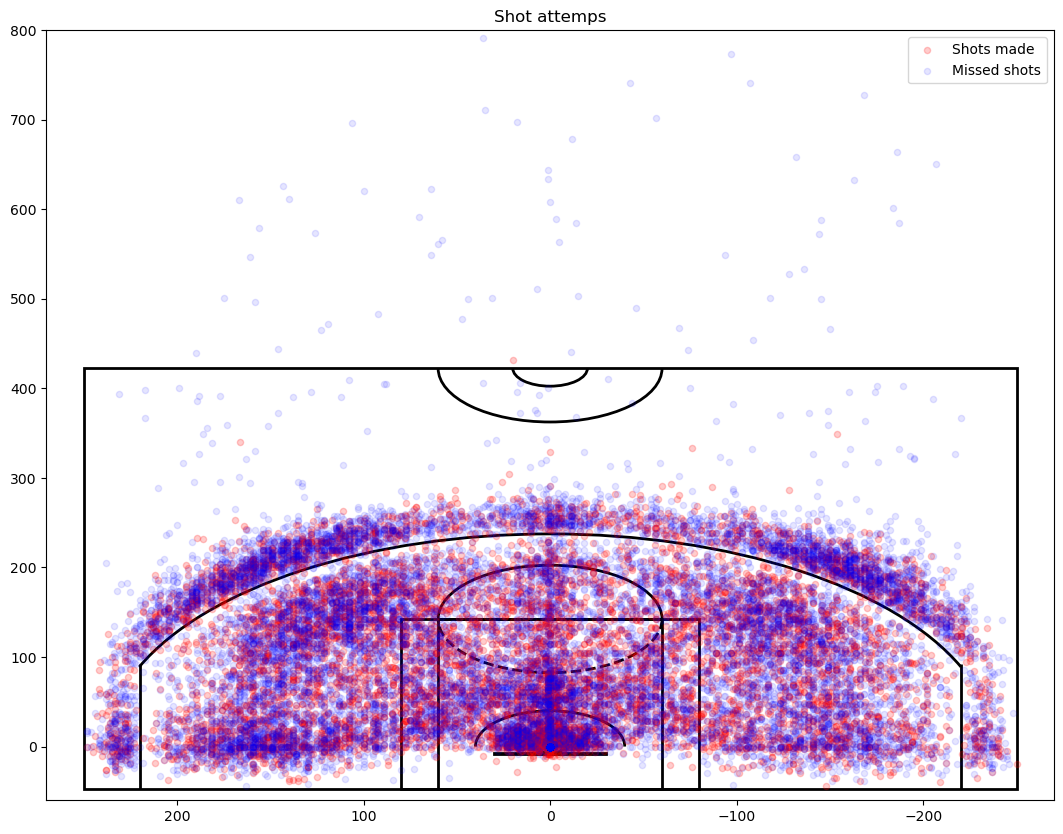

In [68]:
plt.figure(figsize = (13, 10))

draw_court(outer_lines = True)
plt.ylim(-60, 800)
plt.xlim(270, -270)
plt.title('Shot attemps')

plt.scatter(data[data['shot_made_flag'] == 1]['loc_x'], data[data['shot_made_flag'] == 1]['loc_y'], s = 20, alpha = 0.2, c = 'red', label = 'Shots made')
plt.scatter(data[data['shot_made_flag'] == 0]['loc_x'], data[data['shot_made_flag'] == 0]['loc_y'], s = 20, alpha = 0.1, c = 'blue', label = 'Missed shots')

plt.legend()
plt.show()

We can see that Kobe tends to take more shots on his left side, possibly because he is right-handed. Most of his shots for three points and from half-distance are on the right side of the court. Additionally, there are numerous attempts from under the basket and very close to the basket. The distribution on the left side of the court is somewhat similar, though with fewer attempts. What's interesting is that Kobe only made one field goal from his half of the court.

<h2>In progress ...</h2>